In [1]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, RandomCrop, CLAHE, Downscale, GridDistortion, ISONoise,
    Rotate
)
import os
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# NOTE: deprecated function - keeping it for now - just in case
def collect_image_paths_old(base_path, img_type):
    files = []
    for i in list(Path(base_path).rglob(f"**/{img_type}/*.png")):
        files.append(str(i.name))

    return [os.path.join(base_path, i) for i in sorted(files)]


def collect_image_paths(csv, img_type):
    df = pd.read_csv(csv, index_col=0)
    assert img_type in list(df.columns)

    return df[img_type].tolist()


def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.cast(img, tf.float32)
    img /= 255.0
    img = tf.identity(img, name=path.decode().split("/")[-1])
    return img


def load_flood_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32)
    mask /= 255.0
    mask = tf.identity(mask, name=path.decode().split("/")[-1])
    return mask

In [3]:
input_files_csv = "../all_files_harmonized.csv"

In [4]:
inputs_df = pd.read_csv(input_files_csv, index_col=0)
inputs_df = "../" + inputs_df
# images_vv = collect_image_paths(input_files_csv, img_type="vv")
# masks_fld = collect_image_paths(input_files_csv, img_type="flood_label")

# train test split
train_x, test_x = train_test_split(
    inputs_df[["vh", "vv"]].to_numpy(), test_size=0.2, random_state=112
)
train_y, test_y = train_test_split(
    inputs_df["flood_label"].to_numpy(), test_size=0.2, random_state=112
)

In [5]:
input_shape = (256, 256, 2)

In [6]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, RandomCrop, CLAHE, Downscale, GridDistortion, ISONoise,
    Rotate, RandomSizedCrop
)

In [7]:
transforms = Compose([
    RandomBrightness(limit=0.1),
    RandomContrast(limit=0.2, p=0.5),
    HorizontalFlip(),
    Rotate(),
    RandomSizedCrop((200, 200), input_shape[0], input_shape[0]),     
])    

In [8]:
def preprocess(img_path, mask_path):
    def f(img_path, mask_path):
        vh = load_image(img_path[0])
        vv = load_image(img_path[1])
        img = tf.concat([vh, vv], axis=-1)
        mask = load_flood_mask(mask_path)
        
        return img, mask

    image, mask = tf.numpy_function(f, [img_path, mask_path], [tf.float32, tf.float32])
    return image, mask

In [9]:
import albumentations as A

In [10]:
def apply_aug(img, msk):
    def f(img, msk):
        augmented = transforms(image=img, mask=msk)

        image_aug = augmented['image']
        mask_aug = augmented['mask']

        return image_aug, mask_aug
    
    image, mask = tf.numpy_function(f, [img, msk], [tf.float32, tf.float32])
    return image, mask

In [11]:
def apply_aug_fuck(img, msk):
    aug = A.HorizontalFlip(p=1)
#     print(img, msk)
    augmented = aug(image=img, mask=msk)

    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    
    return image_h_flipped, mask_h_flipped

In [12]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(apply_aug, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).repeat(10)
    return dataset

In [17]:
train_dataset = tf_dataset(train_x, train_y, batch=8)

In [18]:
train_x.shape

(26724, 2)

In [19]:
len(train_dataset)

33410

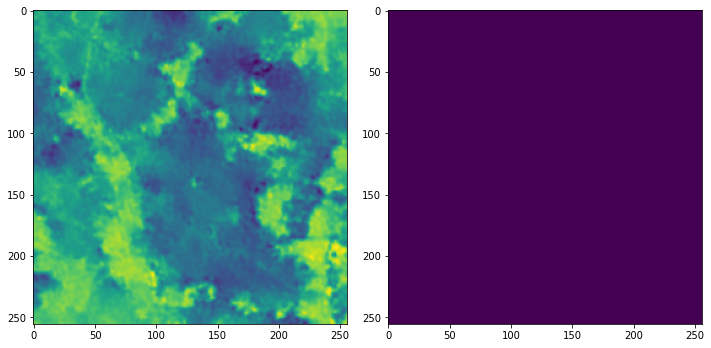

In [16]:
import numpy as np
for img, msk in train_dataset.take(1):
#     print(img.shape, msk.shape)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(np.squeeze(img[0].numpy()[:,:,0]))
    axes[1].imshow(msk[0].numpy())
    fig.tight_layout()